# Goal of this notebook: Plot somatic STR mutation rates across patients. Contrast MSI classifications and unit sizes. Examine indel frequencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

sns.set_context("poster")
%matplotlib inline

In [2]:
df_clinical = pd.read_csv("../../data/dummy_clinical.csv").assign(MSI = lambda x: pd.Categorical(x.MSI, categories=["MSS", "MSI"], ordered=True))
df_somatic_mutations = pd.read_csv("../../data/dummy_somatic_mutation_calls_filt.csv").merge(df_clinical, on="patient")

df_somatic_mutations.head()

,patient,tmp_id,period,ref,allele_a_healthy,allele_a_tumor,allele_b_healthy,allele_b_tumor,allele_a_diff,allele_b_diff,patient_len_diff,MSI
0,1,chr1_10008054,1,14,14,14,14,14,0,0,0,MSS
1,1,chr1_10014276,2,4,4,4,4,4,0,0,0,MSS
2,1,chr1_1004515,2,4,4,4,4,4,0,0,0,MSS
3,1,chr1_10054784,1,19,19,19,19,19,0,0,0,MSS
4,1,chr1_10059809,1,9,9,9,9,9,0,0,0,MSS


## STR mutation rates across patients

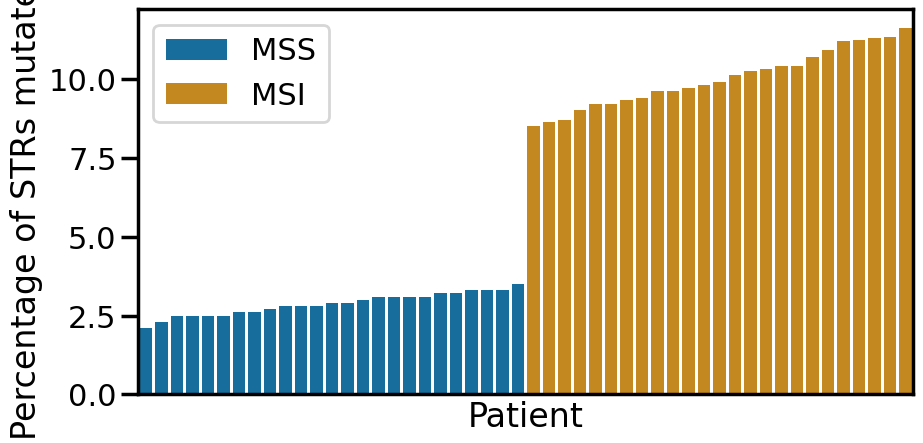

In [3]:
df_barplot_indels = (
    df_somatic_mutations
        .groupby("patient")
        .size()
        .reset_index()
)
df_barplot_indels.columns = ["patient", "total_count"]

df_barplot_indels = df_barplot_indels.merge(
    df_somatic_mutations[df_somatic_mutations["patient_len_diff"] > 0].groupby("patient").size().reset_index(),
    on="patient", how="left"
)

df_barplot_indels.columns = ["patient", "total_count", "variable_count"]
df_barplot_indels["perc_loci_var"] = df_barplot_indels["variable_count"] / df_barplot_indels["total_count"] * 100
df_barplot_indels = df_barplot_indels.merge(df_somatic_mutations[["patient", "MSI"]], on="patient", how="left")
df_barplot_indels = (
    df_barplot_indels
        .drop_duplicates()
        .sort_values(by="perc_loci_var")
        .reset_index(drop=True)
        .assign(patient = lambda x: x.patient.apply(str))
)

fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(
    data = df_barplot_indels,
    x="patient",
    y="perc_loci_var",
    hue="MSI",
    dodge=False,
    palette='colorblind'
)
ax.set(xticks=[], xlabel="Patient", ylabel="Percentage of STRs mutated")
ax.legend(loc='upper left', title="")

plt.show()

In [4]:
mss_avg_var = np.average(df_barplot_indels.query("MSI == 'MSS'").perc_loci_var, weights=df_barplot_indels.query("MSI == 'MSS'").total_count)
msi_avg_var = np.average(df_barplot_indels.query("MSI == 'MSI'").perc_loci_var, weights=df_barplot_indels.query("MSI == 'MSI'").total_count)

print(mss_avg_var, msi_avg_var)


2.868 10.013212155182767


In [5]:
df_somatic_deletions = (df_somatic_mutations
                            .assign(
                                allele_a_diff = lambda x: np.minimum(0, x.allele_a_diff),
                                allele_b_diff = lambda x: np.minimum(0, x.allele_b_diff),
                                patient_len_diff = lambda x: abs(x.allele_a_diff + x.allele_b_diff),
                                mut_type = pd.Categorical(["deletion"] * len(df_somatic_mutations))
                            ))

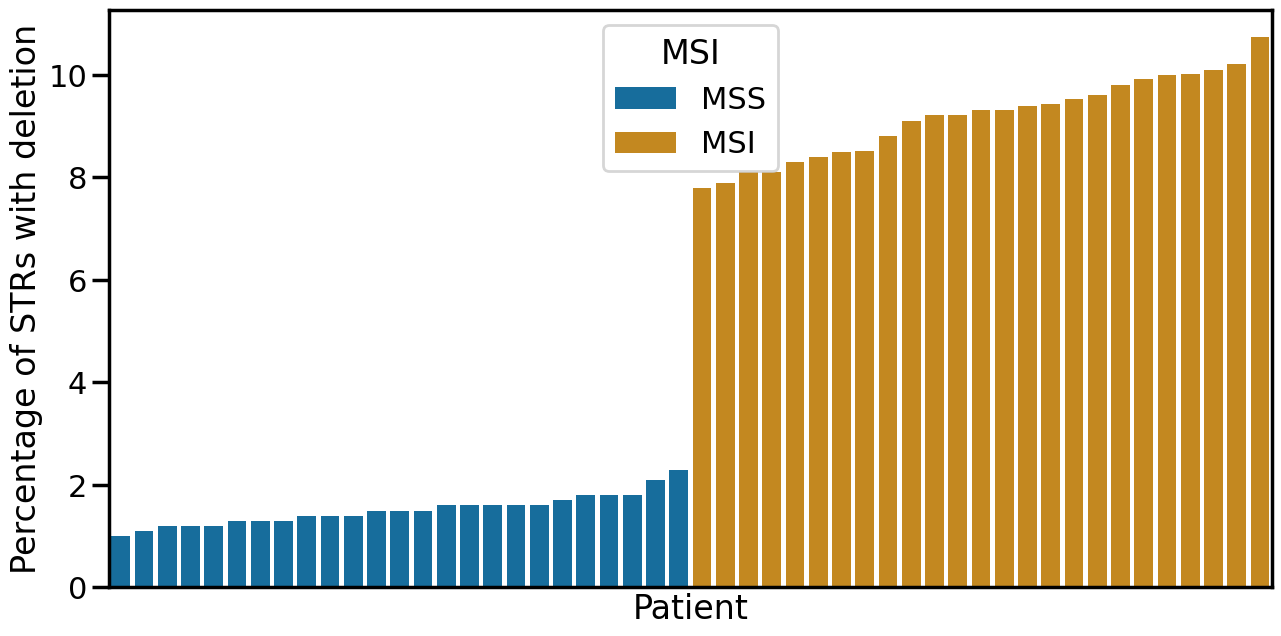

In [6]:
df_barplot_deletions = (
    df_somatic_deletions
        .groupby("patient")
        .size()
        .reset_index()
)
df_barplot_deletions.columns = ["patient", "total_count"]

df_barplot_deletions = df_barplot_deletions.merge(
    df_somatic_deletions[df_somatic_deletions["patient_len_diff"] > 0].groupby("patient").size().reset_index(),
    on="patient", how="left"
)

df_barplot_deletions.columns = ["patient", "total_count", "variable_count"]
df_barplot_deletions["perc_loci_var"] = df_barplot_deletions["variable_count"] / df_barplot_deletions["total_count"] * 100
df_barplot_deletions = df_barplot_deletions.merge(df_somatic_mutations[["patient", "MSI"]], on="patient", how="left")
df_barplot_deletions = (
    df_barplot_deletions
        .drop_duplicates()
        .sort_values(by="perc_loci_var")
        .reset_index(drop=True)
        .assign(patient = lambda x: x.patient.apply(str))
)

fig = plt.figure(figsize=(15, 7.5))

ax = sns.barplot(
    data = df_barplot_deletions.sort_values(by="perc_loci_var"),
    x=df_barplot_deletions.sort_values(by="perc_loci_var")["patient"],
    y=df_barplot_deletions.sort_values(by="perc_loci_var")["perc_loci_var"],
    hue="MSI",
    dodge=False,
    palette="colorblind"
)
ax.set(xticks=[], xlabel="Patient", ylabel="Percentage of STRs with deletion")

plt.show()

In [7]:
df_somatic_insertions = (df_somatic_mutations
                            .assign(
                                allele_a_diff = lambda x: np.maximum(0, x.allele_a_diff),
                                allele_b_diff = lambda x: np.maximum(0, x.allele_b_diff),
                                patient_len_diff = lambda x: abs(x.allele_a_diff + x.allele_b_diff),
                                mut_type = pd.Categorical(["insertion"] * len(df_somatic_mutations))
                            ))

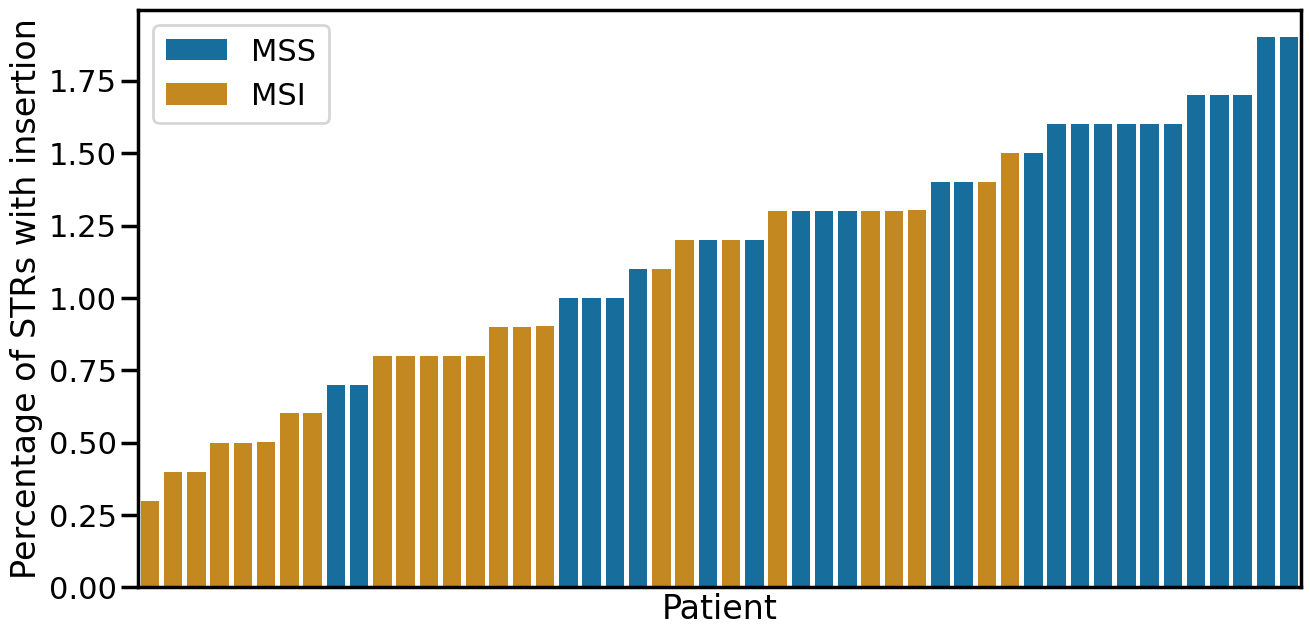

In [8]:
df_barplot_insertions = (
    df_somatic_insertions
        .groupby("patient")
        .size()
        .reset_index()
)
df_barplot_insertions.columns = ["patient", "total_count"]

df_barplot_insertions = df_barplot_insertions.merge(
    df_somatic_insertions[df_somatic_insertions["patient_len_diff"] > 0].groupby("patient").size().reset_index(),
    on="patient", how="left"
)

df_barplot_insertions.columns = ["patient", "total_count", "variable_count"]
df_barplot_insertions["perc_loci_var"] = df_barplot_insertions["variable_count"] / df_barplot_insertions["total_count"] * 100
# df_barplot_insertions = df_barplot_insertions.merge(df_clinical, on="patient", how="left")
df_barplot_insertions = df_barplot_insertions.merge(df_somatic_mutations[["patient", "MSI"]], on="patient", how="left")
df_barplot_insertions = (
    df_barplot_insertions
        .drop_duplicates()
        .sort_values(by="perc_loci_var")
        .reset_index(drop=True)
        .assign(patient = lambda x: x.patient.apply(str))
)

fig = plt.figure(figsize=(15, 7.5))

ax = sns.barplot(
    data = df_barplot_insertions.sort_values(by="perc_loci_var"),
    x=df_barplot_insertions.sort_values(by="perc_loci_var")["patient"],
    y=df_barplot_insertions.sort_values(by="perc_loci_var")["perc_loci_var"],
    hue="MSI",
    dodge=False,
    palette='colorblind'
)
ax.set(xticks=[], xlabel="Patient", ylabel="Percentage of STRs with insertion")
ax.legend(loc='upper left', title="")

plt.show()

In [9]:
from scipy import stats

ttest_indels = stats.mannwhitneyu(
    df_barplot_indels.query("MSI == 'MSS'").perc_loci_var,
    df_barplot_indels.query("MSI == 'MSI'").perc_loci_var
)
print(ttest_indels)

ttest_deletions = stats.mannwhitneyu(
    df_barplot_deletions.query("MSI == 'MSS'").perc_loci_var,
    df_barplot_deletions.query("MSI == 'MSI'").perc_loci_var
)
print(ttest_deletions)

ttest_insertions = stats.mannwhitneyu(
    df_barplot_insertions.query("MSI == 'MSS'").perc_loci_var,
    df_barplot_insertions.query("MSI == 'MSI'").perc_loci_var
)
print(ttest_insertions)

MannwhitneyuResult(statistic=0.0, pvalue=1.3752861483598095e-09)
MannwhitneyuResult(statistic=0.0, pvalue=1.3628835523430495e-09)
MannwhitneyuResult(statistic=523.0, pvalue=4.420640312257425e-05)


In [10]:
target_cols = []
df_somatic_indels = pd.concat([
    df_barplot_deletions.assign(mut_type = pd.Categorical(["deletion"] * len(df_barplot_deletions), categories=["deletion", "insertion"])),
    df_barplot_insertions.assign(mut_type = pd.Categorical(["insertion"] * len(df_barplot_insertions), categories=["deletion", "insertion"]))
]).reset_index(drop=True)

df_somatic_indels

,patient,total_count,variable_count,perc_loci_var,MSI,mut_type
0,2,1000,10,1.0,MSS,deletion
1,8,1000,11,1.1,MSS,deletion
2,4,1000,12,1.2,MSS,deletion
3,22,1000,12,1.2,MSS,deletion
4,25,1000,12,1.2,MSS,deletion
...,...,...,...,...,...,...
95,2,1000,17,1.7,MSS,insertion
96,1,1000,17,1.7,MSS,insertion
97,8,1000,17,1.7,MSS,insertion
98,24,1000,19,1.9,MSS,insertion


/var/folders/2z/jqp3h4fs3lsfdqvrjxl783f00000gn/T/ipykernel_12659/3212852180.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = ax.legend_.legendHandles


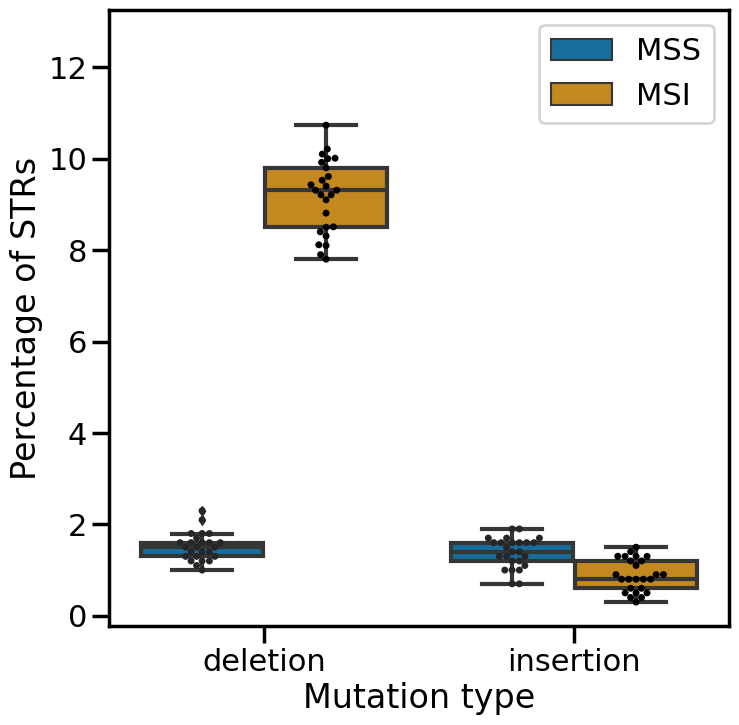

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxplot(
    data = df_somatic_indels,
    x="mut_type",
    y="perc_loci_var",
    hue="MSI",
    palette='colorblind'
)

handles = ax.legend_.legendHandles
labels = [text.get_text() for text in ax.legend_.texts]

sns.swarmplot(
    data = df_somatic_indels,
    x="mut_type",
    y="perc_loci_var",
    hue="MSI",
    dodge=True,
    color="black",
)

ax.set(
    xlabel="Mutation type",
    ylabel="Percentage of STRs",    
    ylim=(None, ax.get_ylim()[1] + 2),
)

plt.legend(handles, labels)

plt.show()

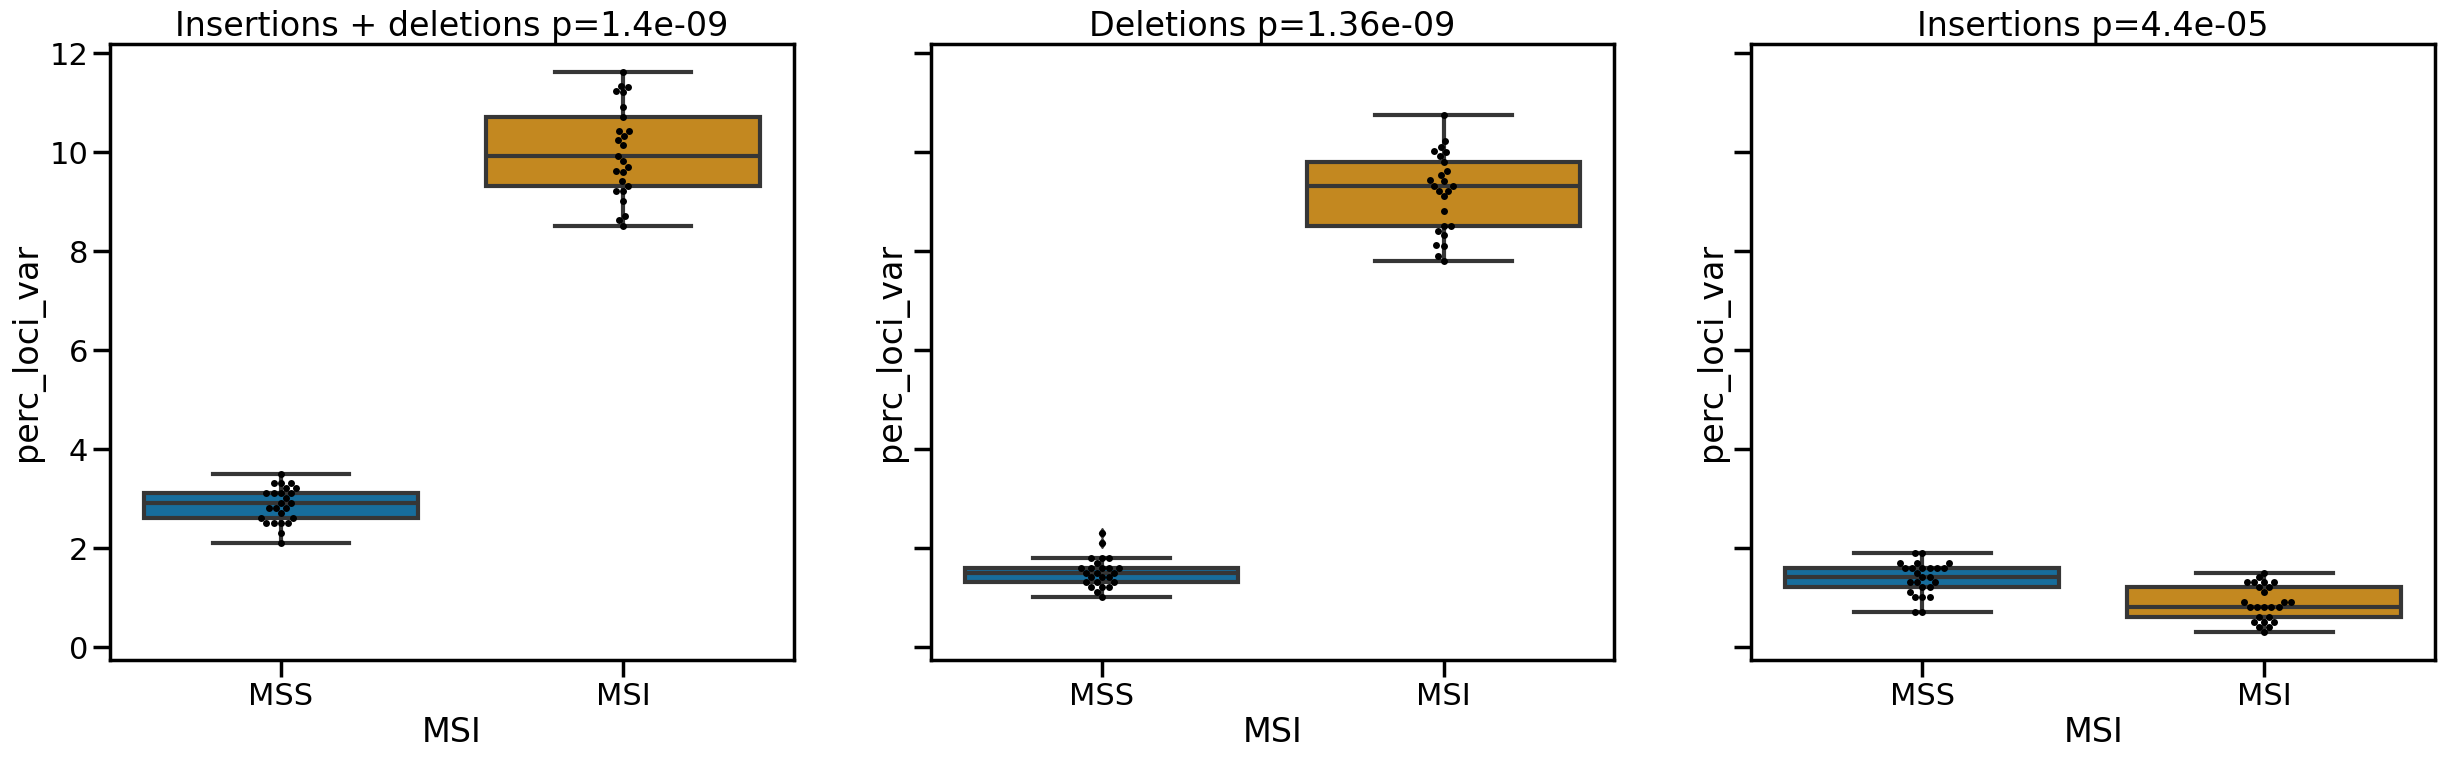

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharex=True, sharey=True)

sns.boxplot(
    data = df_barplot_indels,
    x="MSI",
    y="perc_loci_var",
    ax = axes[0],
    palette='colorblind'
)
sns.swarmplot(
    data = df_barplot_indels,
    x="MSI",
    y="perc_loci_var",
    ax = axes[0],
    color="black"
)
axes[0].set(title = f"Insertions + deletions p={ttest_indels.pvalue:.2}")

sns.boxplot(
    data = df_barplot_deletions,
    x="MSI",
    y="perc_loci_var",
    ax = axes[1],
    palette='colorblind'
)
sns.swarmplot(
    data = df_barplot_deletions,
    x="MSI",
    y="perc_loci_var",
    ax = axes[1],
    color="black"
)
axes[1].set(title = f"Deletions p={ttest_deletions.pvalue:.3}")

sns.boxplot(
    data = df_barplot_insertions,
    x="MSI",
    y="perc_loci_var",
    ax = axes[2],
    palette='colorblind'
)
sns.swarmplot(
    data = df_barplot_insertions,
    x="MSI",
    y="perc_loci_var",
    ax = axes[2],
    color="black"
)
axes[2].set(title = f"Insertions p={ttest_insertions.pvalue:.2}")

plt.show()

## STR mutation rates as a function of unit size

In [13]:
df_barplot_usize = (
    df_somatic_mutations
        # .merge(df_clinical[['patient', 'MSI']], on='patient')
#         .merge(df_str_info[['tmp_id', 'region_type']], on='tmp_id')
        .groupby(["MSI", "period"])
        .size()
        .reset_index()
)

df_barplot_usize.columns = ["MSI", "period", "total_count"]

df_barplot_usize = df_barplot_usize.merge(
    df_somatic_mutations[df_somatic_mutations["patient_len_diff"] > 0]
        # .merge(df_clinical[['patient', 'MSI']], on='patient')
#         .merge(df_str_info[['tmp_id', 'region_type']], on='tmp_id')
        .groupby(["MSI", "period"])
        .size()
        .reset_index(),
    on=["MSI", "period"], 
    how="left"
)
df_barplot_usize.columns = ["MSI", "period", "total_count", "variable_count"]

df_barplot_usize["perc_loci_var"] = df_barplot_usize["variable_count"] / df_barplot_usize["total_count"] * 100

df_barplot_usize

,MSI,period,total_count,variable_count,perc_loci_var
0,MSS,1,6650,185,2.781955
1,MSS,2,9850,289,2.934010
2,MSS,3,2775,72,2.594595
3,MSS,4,3850,121,3.142857
4,MSS,5,1425,41,2.877193
5,MSS,6,450,9,2.000000
6,MSI,1,6647,648,9.748759
7,MSI,2,9843,1003,10.189983
8,MSI,3,2772,262,9.451659
9,MSI,4,3843,388,10.096279


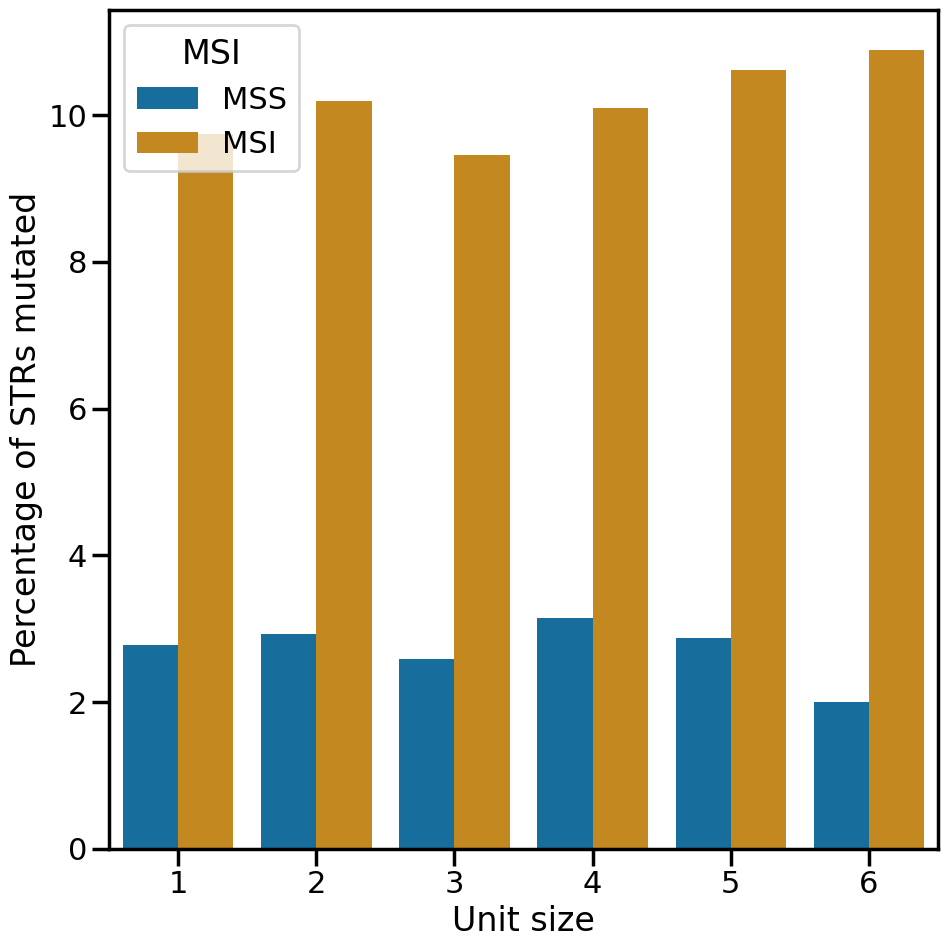

In [14]:
fig = plt.figure(figsize = (10, 10))

ax = sns.barplot(
    data = df_barplot_usize,
    x = 'period',
    y = 'perc_loci_var',
    hue='MSI',
    palette='colorblind'
)

ax.set(
    xlabel="Unit size", 
    ylabel="Percentage of STRs mutated",
#     ylim=(0, 5)
)

plt.tight_layout()

In [15]:
for period in range(1, 7):
    total_mss = int(df_barplot_usize.loc[(df_barplot_usize.period == period) & (df_barplot_usize["MSI"] == 'MSS'), :].total_count)
    mutated_mss = int(df_barplot_usize.loc[(df_barplot_usize.period == period) & (df_barplot_usize["MSI"] == 'MSS'), :].variable_count)
    
    total_msi = int(df_barplot_usize.loc[(df_barplot_usize.period == period) & (df_barplot_usize["MSI"] == 'MSI'), :].total_count)
    mutated_msi = int(df_barplot_usize.loc[(df_barplot_usize.period == period) & (df_barplot_usize["MSI"] == 'MSI'), :].variable_count)
    
    res = stats.fisher_exact(
        table = np.array([[total_msi, mutated_msi], [total_mss, mutated_mss]])
    )
    print(period, res)
    

1 SignificanceResult(statistic=0.28536503295275223, pvalue=8.307482881359139e-58)
2 SignificanceResult(statistic=0.28793082680891335, pvalue=1.8282235336683908e-87)
3 SignificanceResult(statistic=0.2745120693212296, pvalue=2.5195820857532576e-25)
4 SignificanceResult(statistic=0.3112886597938144, pvalue=5.436833770894455e-32)
5 SignificanceResult(statistic=0.27095155106308816, pvalue=3.392765255986239e-15)
6 SignificanceResult(statistic=0.1836734693877551, pvalue=1.9980827431633356e-07)
